In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pickle

from adaptive_time.utils import set_directory_in_project

from importlib import reload
from tqdm.notebook import tqdm

from pprint import pprint


In [2]:
set_directory_in_project()

Changed working directory to /Users/chanb/research/ualberta/adaptive_time


'/Users/chanb/research/ualberta/adaptive_time'

In [3]:
reward_sequences = np.load(
    "./data/ant/Rewards_50000_1000_100.npy"
).T
print(reward_sequences.shape)

(1000, 50000)


In [4]:
dt = 0.001

In [5]:
# Check if same initial reward (likely same state if so)
np.where(reward_sequences[0, :][:, None] - reward_sequences[0, :][None, :] == 0)

(array([    0,     1,     2, ..., 49997, 49998, 49999]),
 array([    0,     1,     2, ..., 49997, 49998, 49999]))

In [6]:
from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)

In [7]:
samplers_tried = dict(
    q10=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=10),
    q1=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=1),
    q0=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=0),
    u1=approx_integrators.UniformlySpacedIntegrator(1),
    u10=approx_integrators.UniformlySpacedIntegrator(50),
    u100=approx_integrators.UniformlySpacedIntegrator(500),
)

In [8]:
approx_integrals = {}
num_pivots = {}

for sampler_name, sampler in tqdm(samplers_tried.items()):
    print("sampler_name:", sampler_name)
    approx_integrals[sampler_name] = []
    num_pivots[sampler_name] = []
    for idx, reward_seq in enumerate(reward_sequences):
        integral, all_pivots = sampler.integrate(reward_seq)
        approx_integrals[sampler_name].append(integral)
        num_pivots[sampler_name].append(len(all_pivots))
    approx_integrals[sampler_name] = np.array(approx_integrals[sampler_name])
    num_pivots[sampler_name] = np.array(num_pivots[sampler_name])



  0%|          | 0/6 [00:00<?, ?it/s]

sampler_name: q10
sampler_name: q1
sampler_name: q0
sampler_name: u1
sampler_name: u10
sampler_name: u100


In [12]:
pickle.dump([approx_integrals, num_pivots], open("./data/mujoco_val_est.pkl", "wb"))

In [30]:
update_budget = 100_000_000

estimated_values_by_episode = {}
number_of_pivots_by_episode = {}
all_values_by_episode = {}
weights = np.ones(len(reward_sequences)) / len(reward_sequences)

true_value = np.sum(weights * np.sum(reward_sequences, axis=-1))

for sampler_name, sampler in tqdm(samplers_tried.items()):
    print("sampler_name:", sampler_name)
    # Update the value estimate with new samples until we run out of budget.
    used_updates = 0
    value_estimate = 0
    num_samples = 0
    all_values_by_episode[sampler_name] = []
    # empirical_state_distr = np.zeros((num_trajs))

    estimated_values_by_episode[sampler_name] = []
    number_of_pivots_by_episode[sampler_name] = []

    while used_updates < update_budget:
        num_samples += 1
        start_state = np.random.choice(len(reward_sequences), p=weights)
        # empirical_state_distr[start_state] += 1
        val_sample = approx_integrals[sampler_name][start_state]
        all_values_by_episode[sampler_name].append(val_sample)
        
        value_estimate += (1.0/num_samples) * (val_sample - value_estimate)
        used_updates += num_pivots[sampler_name][start_state]

        estimated_values_by_episode[sampler_name].append(value_estimate)
        number_of_pivots_by_episode[sampler_name].append(used_updates)
    
    # empirical_state_distr /= np.sum(empirical_state_distr)
    # empirical_value = approx_integrals[sampler_name] @ empirical_state_distr


# CODE TO SAMPLE MANY TRAJECOTRIES TO FIND AN EMPIRICAL DISTRIBUTION 
# episode_samples = 100_000
# sampled_start_states = np.random.choice(num_trajs, size=(episode_samples,), p=weights)
# # We now have samples, we determine the empirical state distribution.
# empirical_state_distr = np.zeros((num_trajs))
# values, counts = np.unique(sampled_start_states, return_counts=True)
# empirical_state_distr[values] = counts
# empirical_state_distr /= np.sum(empirical_state_distr)


  0%|          | 0/6 [00:00<?, ?it/s]

sampler_name: q10
sampler_name: q1
sampler_name: q0
sampler_name: u1
sampler_name: u10
sampler_name: u100


In [31]:
# Verify final means.
for key, value in estimated_values_by_episode.items():
    mean_total = np.mean(all_values_by_episode[key])
    mean_updated = value[-1]
    print("sampler:", key, "mean_total:", mean_total, "mean_updated:", mean_updated)
    if abs(mean_total - mean_updated) > 0.01:
        assert False, f"Means don't match for {key}: {mean_total} vs {mean_updated}"
    


sampler: q10 mean_total: 124139.21153878568 mean_updated: 124139.21153878552
sampler: q1 mean_total: 124119.23432829564 mean_updated: 124119.23432829553
sampler: q0 mean_total: 124160.50577917261 mean_updated: 124160.50577917266
sampler: u1 mean_total: 124055.25139130131 mean_updated: 124055.25139130151
sampler: u10 mean_total: 124118.11180921398 mean_updated: 124118.1118092142
sampler: u100 mean_total: 124609.89963308511 mean_updated: 124609.89963308394


Text(0.5, 0, 'Number of Samples')

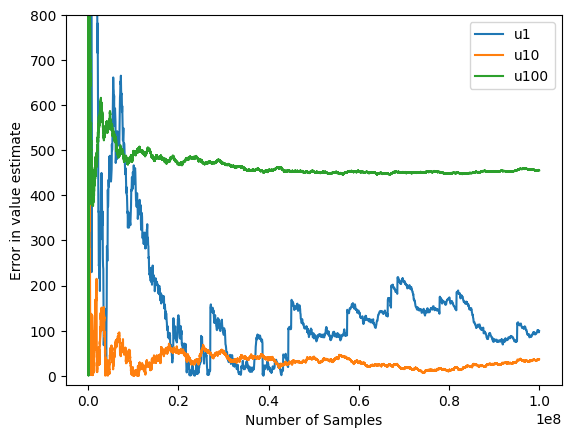

In [32]:
for s in samplers_tried.keys():
    if "q" in s:
        continue
    plt.plot(
        number_of_pivots_by_episode[s],
        np.abs(estimated_values_by_episode[s]-true_value),
        label=s)

plt.legend()
plt.ylabel("Error in value estimate")
plt.ylim(-20, 800)
plt.xlabel("Number of Samples")

Text(0.5, 0, 'Number of Samples')

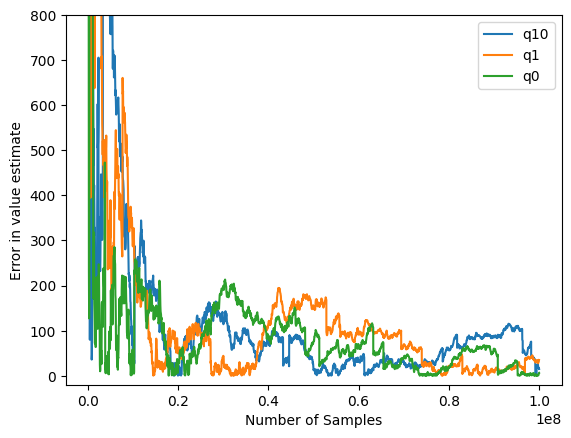

In [33]:
for s in samplers_tried.keys():
    if "q" not in s:
        continue
    plt.plot(
        number_of_pivots_by_episode[s],
        np.abs(estimated_values_by_episode[s]-true_value),
        label=s)

plt.legend()
plt.ylabel("Error in value estimate")
plt.ylim(-20, 800)
plt.xlabel("Number of Samples")

Text(0.5, 0, 'Number of Samples')

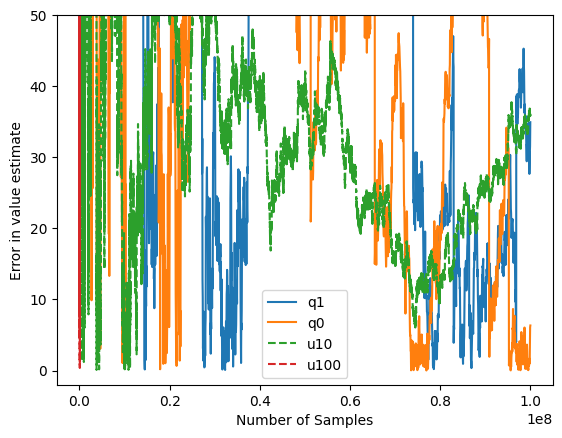

In [34]:
s_to_plot = ["q1", "q0", "u10", "u100"]
# for s in samplers_tried.keys():
for s in s_to_plot:
    linestyle = "-" if "q" in s else "--"
    plt.plot(
        number_of_pivots_by_episode[s],
        np.abs(estimated_values_by_episode[s]-true_value),
        label=s, linestyle=linestyle)

plt.legend()
plt.ylabel("Error in value estimate")
plt.ylim(-2, 50)
plt.xlabel("Number of Samples")